In [1]:
!unzip "sample_data/part_2_cnn_dataset.zip" -d "sample_data/part_2_cnn_dataset"

Archive:  sample_data/part_2_cnn_dataset.zip
replace sample_data/part_2_cnn_dataset/dogs/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Vision Transformer (ViT) [7 pts]

## **TASK 1:** Implement Vision Transformer

Implement a [Vision Transformer](https://arxiv.org/abs/2010.11929).

Use it to solve a problem defined in Assignment 1, Part II

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Folder path and classes
data_dir = 'sample_data/part_2_cnn_dataset'
classes = ['vehicles', 'food', 'dogs']

# Load images
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = Image.open(img_path).resize((64, 64))  # Ensure the images are 64x64
        img_array = np.array(img)
        if img_array.shape == (64, 64, 3):  # Ensure the image is in RGB format
            images.append(img_array)
            labels.append(label)
    return images, labels

all_images = []
all_labels = []

for idx, class_name in enumerate(classes):
    folder_path = os.path.join(data_dir, class_name)
    images, labels = load_images_from_folder(folder_path, idx)
    all_images.extend(images)
    all_labels.extend(labels)

# Convert images to numpy arrays
all_images = np.array(all_images)
all_labels = np.array(all_labels)

print(f"Total number of images: {len(all_images)}")
print(f"Image array shape: {all_images.shape}")
print(f"Label array shape: {all_labels.shape}")


Total number of images: 30000
Image array shape: (30000, 64, 64, 3)
Label array shape: (30000,)


Display sample images

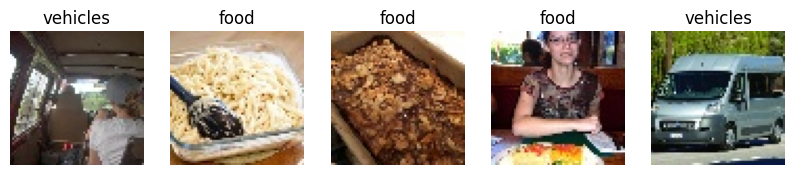

In [2]:
# sample images
def display_sample_images(images, labels, classes, num_samples=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        index = np.random.randint(0, len(images))
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[index])
        plt.title(classes[labels[index]])
        plt.axis('off')
    plt.show()

display_sample_images(all_images, all_labels, classes)


VGG-13 Version B model

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

# Define VGG-13 Version B model with 13 weight layers
class VGG13(nn.Module):
    def __init__(self, num_classes=3): # 3 classes
        super(VGG13, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Model creation
model = VGG13(num_classes=3)
print(model)


VGG13(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16)

Data augmentation, normalization and dataset split

In [4]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Data augmentation and normalization
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(9),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.489, 0.446, 0.416], std=[0.309, 0.254, 0.125]),
])

dataset = CustomDataset(all_images, all_labels, transform=transform)

# create train_dataset and val_dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# create train_loader, val_loader and test_loader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

Training the model

In [5]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=10)

num_epochs = 5
best_val_loss = float('inf')
patience = 10
early_stopping_counter = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop with epoch
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    # print(len(train_loader))
    # i=0
    for inputs, labels in train_loader:
        # i=i+1
        # print(i)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        i, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    # j=0
    with torch.no_grad():
        for inputs, labels in val_loader:
            # j=j+1
            # print(j)
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            i, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Update learning rate scheduler
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save best model weights to pickle file
        torch.save(model.state_dict(), 'dsivapra_ganeshpr.pkl')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping triggered")
            break

    print(f"Epoch {epoch+1},\n "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%,\n "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%\n")

# Load best model weights from pickle file
model.load_state_dict(torch.load('dsivapra_ganeshpr.pkl'))

Epoch 1,
 Train Loss: 0.7384, Train Accuracy: 67.63%,
 Validation Loss: 0.4874, Validation Accuracy: 81.42%

Epoch 2,
 Train Loss: 0.5119, Train Accuracy: 80.21%,
 Validation Loss: 0.4312, Validation Accuracy: 83.43%

Epoch 3,
 Train Loss: 0.4164, Train Accuracy: 84.40%,
 Validation Loss: 0.3298, Validation Accuracy: 87.42%

Epoch 4,
 Train Loss: 0.3768, Train Accuracy: 86.14%,
 Validation Loss: 0.3133, Validation Accuracy: 88.30%

Epoch 5,
 Train Loss: 0.3505, Train Accuracy: 87.45%,
 Validation Loss: 0.3230, Validation Accuracy: 88.62%



<All keys matched successfully>

Calculate Test loss and accuracy

In [6]:
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        i, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_loss /= len(test_loader)
test_accuracy = 100 * correct_test / total_test

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.3171, Test Accuracy: 88.30%


Plotting training and validation accuracy and loss

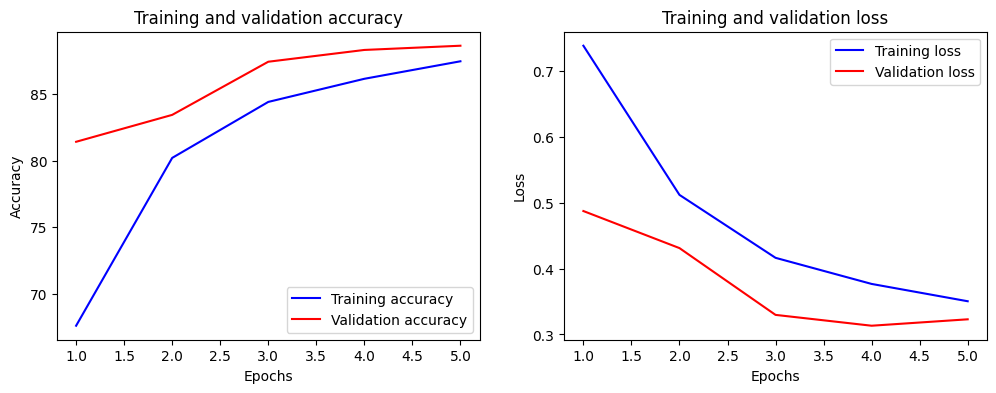

In [7]:
# Plotting training and validation accuracy and loss
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Confusion Matrix and evaluation metrics

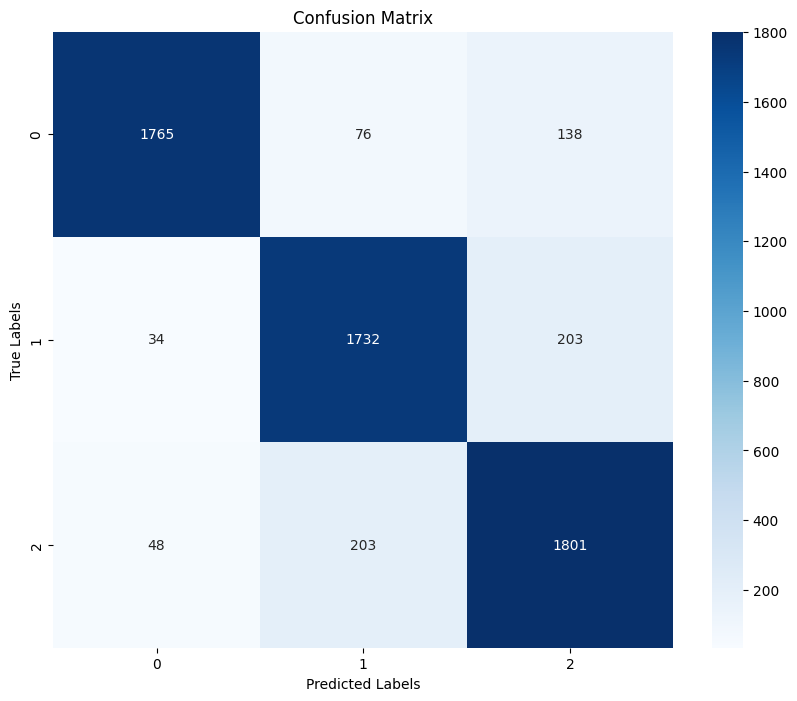

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.89      0.92      1979
           1       0.86      0.88      0.87      1969
           2       0.84      0.88      0.86      2052

    accuracy                           0.88      6000
   macro avg       0.89      0.88      0.88      6000
weighted avg       0.89      0.88      0.88      6000



In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(all_labels, all_predictions))

ViT Implementation

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, ff_dim, dropout):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(dim, num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(dim)
        self.ff = nn.Sequential(
            nn.Linear(dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, dim)
        )
        self.norm2 = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        x = x + self.dropout(attn_output)
        x = self.norm1(x)
        ff_output = self.ff(x)
        x = x + self.dropout(ff_output)
        x = self.norm2(x)
        return x

class ViT(nn.Module):
    def __init__(self, image_size=64, patch_size=16, num_classes=3, dim=128, depth=6, heads=8, mlp_dim=256, dropout=0.1, emb_dropout=0.1):
        super(ViT, self).__init__()
        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = 3 * patch_size * patch_size

        self.patch_size = patch_size
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.to_patch_embedding = nn.Linear(patch_dim, dim)

        self.dropout = nn.Dropout(emb_dropout)
        self.transformer = nn.Sequential(
            *[TransformerBlock(dim, heads, mlp_dim, dropout) for _ in range(depth)]
        )

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        p = self.patch_size
        x = img.reshape(img.shape[0], 3, p, p, img.shape[2] // p, img.shape[3] // p)
        x = x.permute(0, 2, 4, 3, 5, 1).contiguous().reshape(img.shape[0], -1, 3 * p * p)
        x = self.to_patch_embedding(x)
        b, n, _ = x.shape

        cls_tokens = self.cls_token.expand(b, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)
        x = x.permute(1, 0, 2)
        x = self.transformer(x)
        x = x.permute(1, 0, 2)
        x = x[:, 0]

        return self.mlp_head(x)

# Model creation
vit_model = ViT(num_classes=3)
print(vit_model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=10)

num_epochs = 5
best_val_loss = float('inf')
patience = 10
early_stopping_counter = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model.to(device)

train_losses_vit = []
val_losses_vit = []
train_accuracies_vit = []
val_accuracies_vit = []

for epoch in range(num_epochs):
    vit_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = vit_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses_vit.append(train_loss)
    train_accuracies_vit.append(train_accuracy)

    vit_model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = vit_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses_vit.append(val_loss)
    val_accuracies_vit.append(val_accuracy)

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(vit_model.state_dict(), 'vit_best_model.pkl')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping triggered")
            break

    print(f"Epoch {epoch+1},\n "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%,\n "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%\n")

# Load best model weights from pickle file
vit_model.load_state_dict(torch.load('vit_best_model.pkl'))
vit_model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = vit_model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_loss /= len(test_loader)
test_accuracy = 100 * correct_test / total_test

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Classification Report for ViT
print("Classification Report for ViT:\n", classification_report(all_labels, all_predictions))


ViT(
  (to_patch_embedding): Linear(in_features=768, out_features=128, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Sequential(
    (0): TransformerBlock(
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ff): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=128, bias=True)
      )
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ff): Sequential(
        (0): Linear(in_features=12

## **TASK 2:** Compare the Results with VGG

Compared with same batchsize, epochs, learning rate, etc

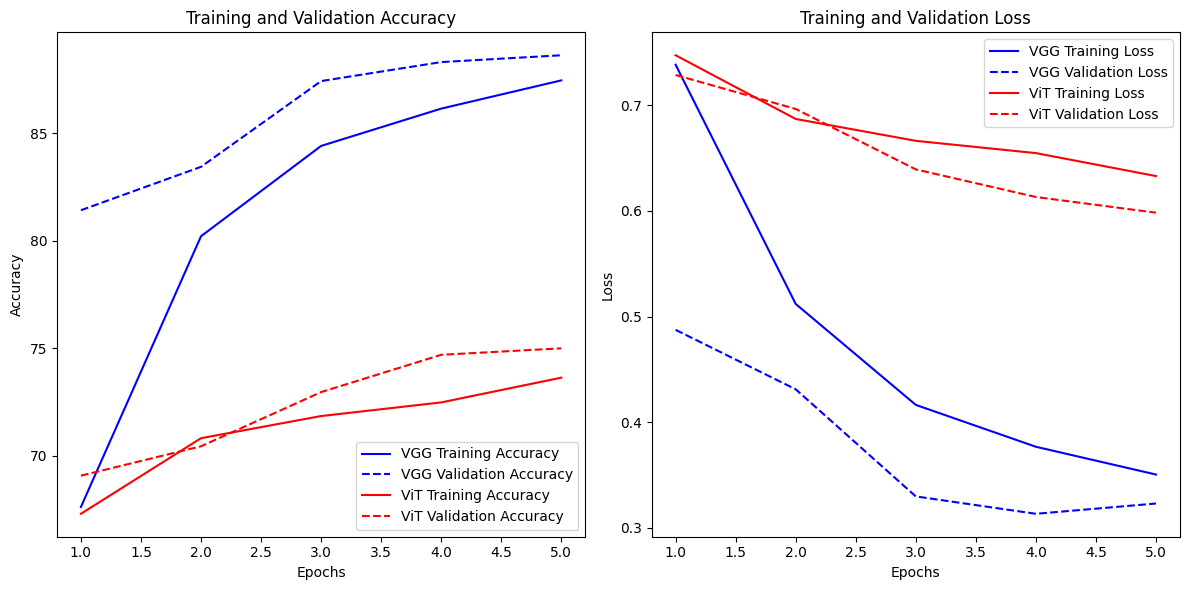

In [17]:
# Combined plot for accuracy and loss comparison
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 6))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, 'b-', label='VGG Training Accuracy')
plt.plot(epochs, val_accuracies, 'b--', label='VGG Validation Accuracy')
plt.plot(epochs, train_accuracies_vit, 'r-', label='ViT Training Accuracy')
plt.plot(epochs, val_accuracies_vit, 'r--', label='ViT Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, 'b-', label='VGG Training Loss')
plt.plot(epochs, val_losses, 'b--', label='VGG Validation Loss')
plt.plot(epochs, train_losses_vit, 'r-', label='ViT Training Loss')
plt.plot(epochs, val_losses_vit, 'r--', label='ViT Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## **References**

Include all the references that have been used to complete the assignment.

Used after changing the hyperparameters in Assignment1 part2 code for VGG model implementation, training and evaluation. REF: dsivapra_rkota2_assignment1_part_2